 # Insurance Premium Prediction - Kaggle Playground Series S4E12

 Author: Ahmad AlModhayan

 Date: 2024-12-12

 ## 1. Problem Definition



 ### Objective

 Develop a machine learning model to predict insurance premiums based on various customer attributes.



 ### Success Metrics

 - Primary: Root Mean Squared Logarithmic Error (RMSLE)

 - Secondary: Model interpretability and feature importance

 ## 2. Data Collection and Setup

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import psutil
from typing import Dict, List, Tuple, Optional, Union

# Machine Learning imports
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings

# Constants
RANDOM_STATE = 42

# Setup
warnings.filterwarnings('ignore')
np.random.seed(RANDOM_STATE)

### Pipline Monitor

In [4]:
class PipelineMonitor:
    def __init__(self):
        self.start_time = time.time()
        self.checkpoints = {}

    def checkpoint(self, name: str) -> None:
        """Record time taken since last checkpoint"""
        current_time = time.time()
        time_taken = current_time - self.start_time
        self.checkpoints[name] = time_taken
        self.start_time = current_time

    def get_memory_usage(self) -> float:
        """Get current memory usage in MB"""
        process = psutil.Process()
        return process.memory_info().rss / 1024 / 1024

# Initialize pipeline monitor
monitor = PipelineMonitor()

In [5]:
print("Loading data...")
data_dir = Path("data")
train_path = data_dir / "train.csv"
test_path = data_dir / "test.csv"


try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: Data files not found. Please ensure the data files are in the 'data' directory.\nError: {e}")
    raise


Loading data...
Data loaded successfully!


## 3. Exploratory Data Analysis

In [6]:
def perform_eda(df: pd.DataFrame, is_train: bool = True) -> None:
    """
    Perform exploratory data analysis on the dataset

    Parameters:
        df: Input DataFrame
        is_train: Whether this is training data (includes target variable)
    """
    print(f"\nExploratory Data Analysis {'(Training Data)' if is_train else '(Test Data)'}")

    # Basic information
    print("\n1. Basic Information:")
    print("-" * 50)
    print("\nDataset Shape:", df.shape)
    print("\nFeature Types:")
    print(df.dtypes)

    # Missing values analysis
    print("\n2. Missing Values Analysis:")
    print("-" * 50)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    print(missing_info[missing_info['Missing Values'] > 0])

    # Numerical features analysis
    print("\n3. Numerical Features Analysis:")
    print("-" * 50)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_summary = df[numeric_cols].describe()
    print(numeric_summary)

    # Categorical features analysis
    print("\n4. Categorical Features Analysis:")
    print("-" * 50)
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"\nUnique values in {col}:", df[col].nunique())
        print("\nTop 5 categories:")
        print(df[col].value_counts().head())

    # Visualizations
    print("\n5. Visualizations:")
    print("-" * 50)

    # Distribution plots for numerical features
    plt.figure(figsize=(15, 5 * ((len(numeric_cols) + 2) // 3)))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot((len(numeric_cols) + 2) // 3, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Box plots for numerical features
    plt.figure(figsize=(15, 5 * ((len(numeric_cols) + 2) // 3)))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot((len(numeric_cols) + 2) // 3, 3, i)
        sns.boxplot(y=df[col])
        plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()

    if is_train:
        # Correlation analysis
        plt.figure(figsize=(12, 8))
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()
        plt.show()

        # Target variable analysis
        target_col = 'Premium Amount'
        if target_col in df.columns:
            plt.figure(figsize=(12, 5))

            # Target distribution
            plt.subplot(1, 2, 1)
            sns.histplot(df[target_col], kde=True)
            plt.title('Distribution of Premium Amount')

            # Log-transformed target distribution
            plt.subplot(1, 2, 2)
            sns.histplot(np.log1p(df[target_col]), kde=True)
            plt.title('Distribution of Log-transformed Premium Amount')

            plt.tight_layout()
            plt.show()

            # Relationship between target and numerical features
            plt.figure(figsize=(15, 5 * ((len(numeric_cols) - 1 + 2) // 3)))
            for i, col in enumerate([c for c in numeric_cols if c != target_col], 1):
                plt.subplot((len(numeric_cols) - 1 + 2) // 3, 3, i)
                plt.scatter(df[col], df[target_col], alpha=0.5)
                plt.xlabel(col)
                plt.ylabel(target_col)
                plt.title(f'{col} vs {target_col}')
            plt.tight_layout()
            plt.show()

            # Box plots of target by categorical features
            for col in categorical_cols:
                if df[col].nunique() < 10:  # Only plot if there aren't too many categories
                    plt.figure(figsize=(10, 6))
                    sns.boxplot(x=col, y=target_col, data=df)
                    plt.title(f'{target_col} by {col}')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()


Performing EDA on training data...

Exploratory Data Analysis (Training Data)

1. Basic Information:
--------------------------------------------------

Dataset Shape: (1200000, 21)

Feature Types:
id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score            float64
Location                 object
Policy Type              object
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date        object
Customer Feedback        object
Smoking Status           object
Exercise Frequency       object
Property Type            object
Premium Amount          float64
dtype: object

2. Missing Values Analysis:
--------------------------------------------------
                      Missing Value

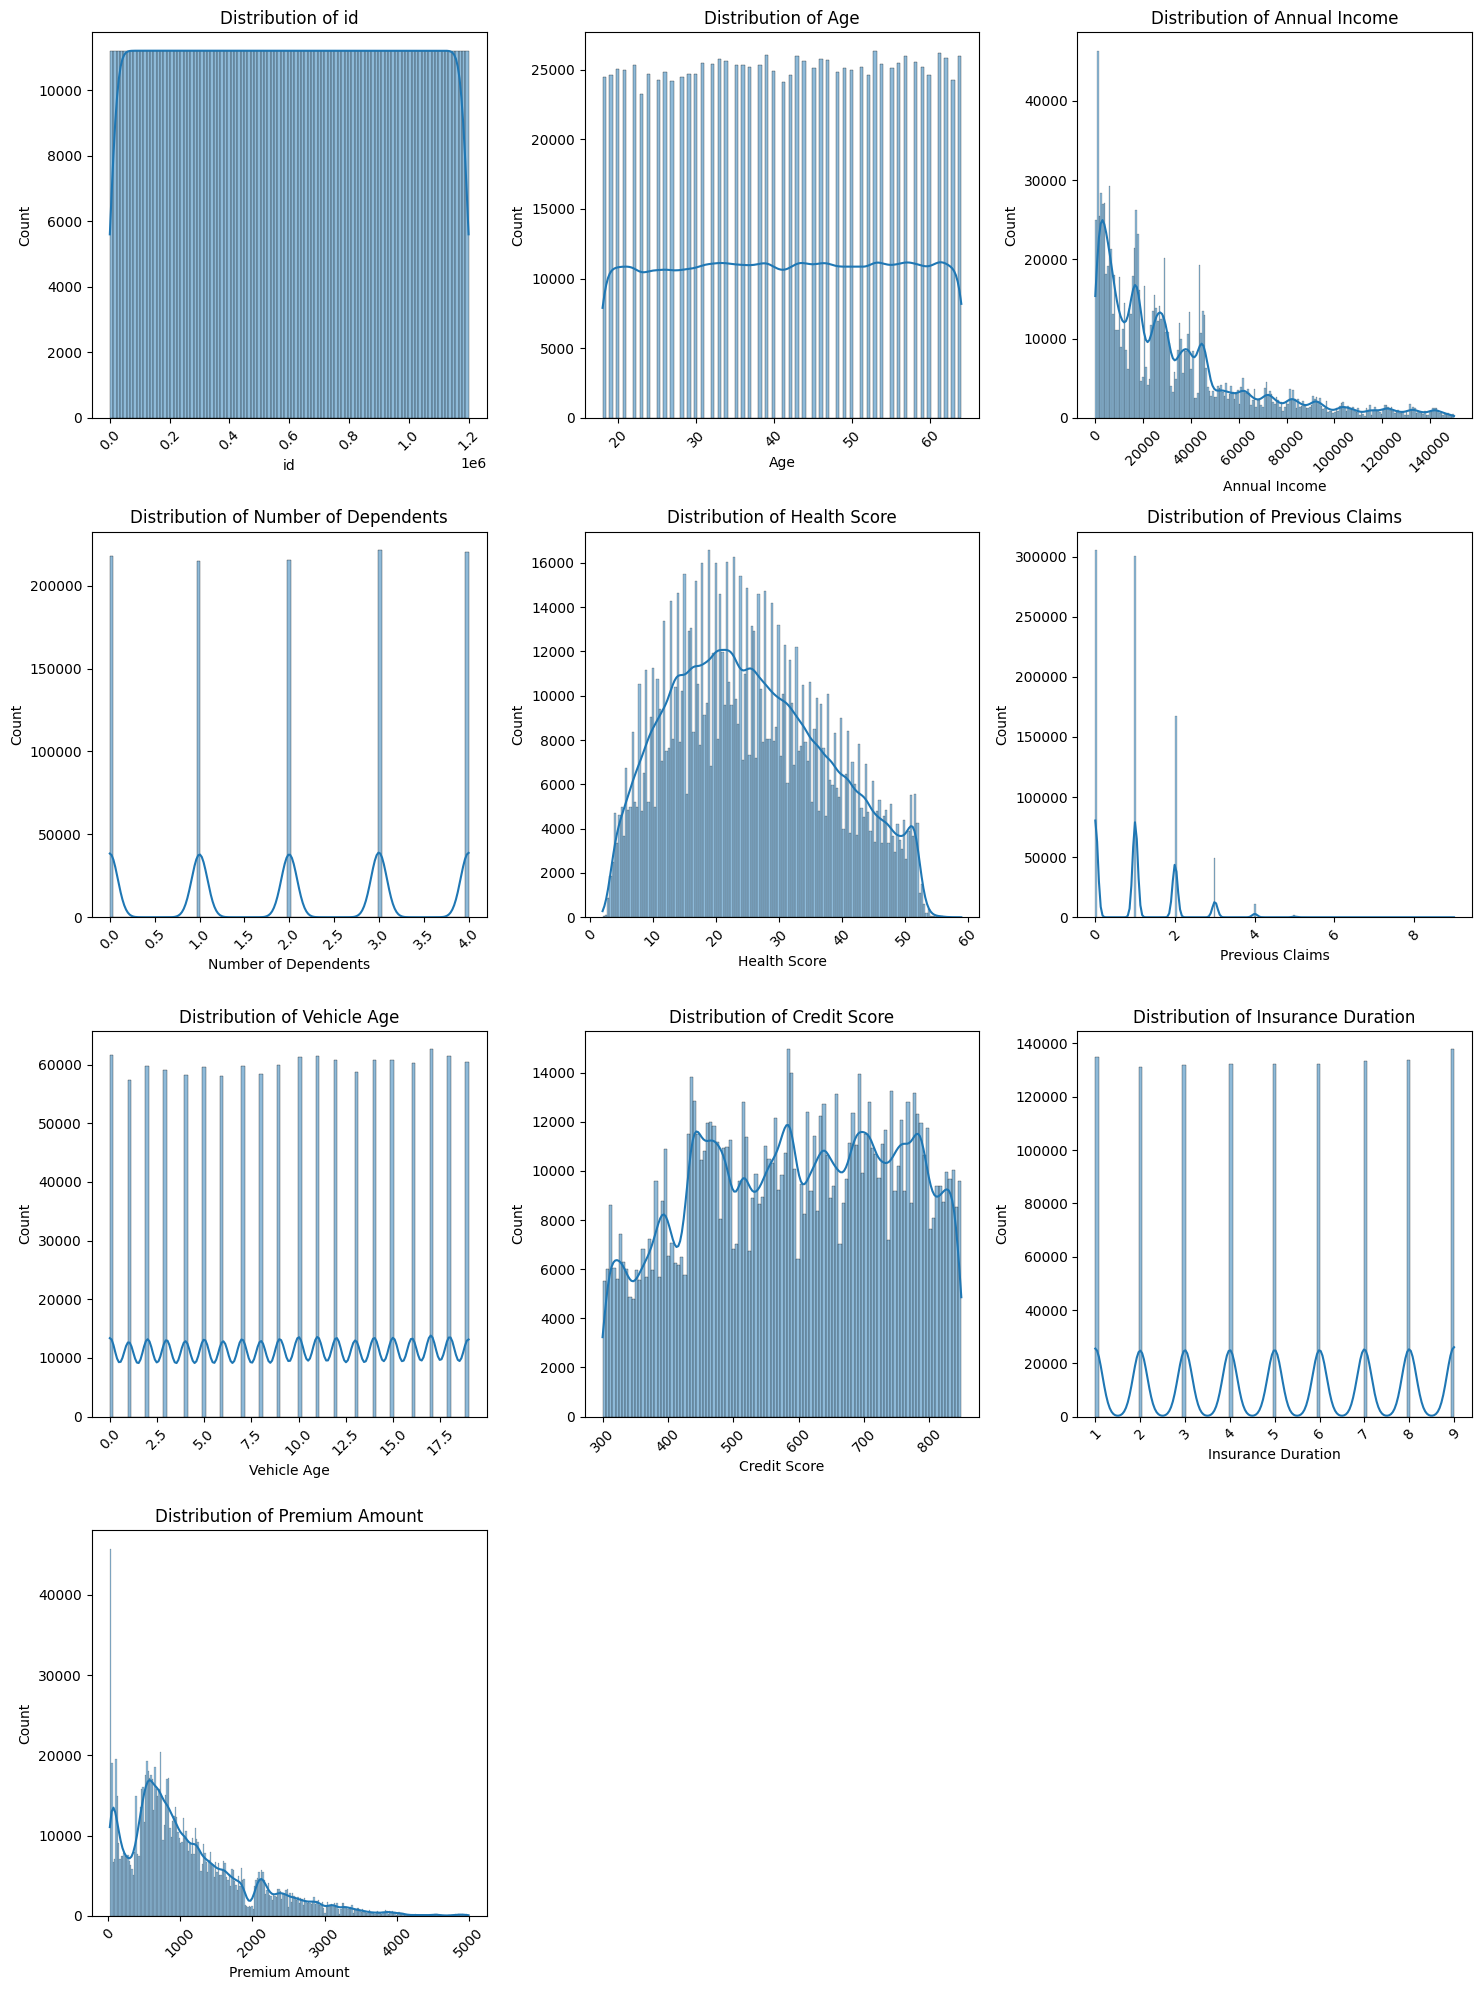

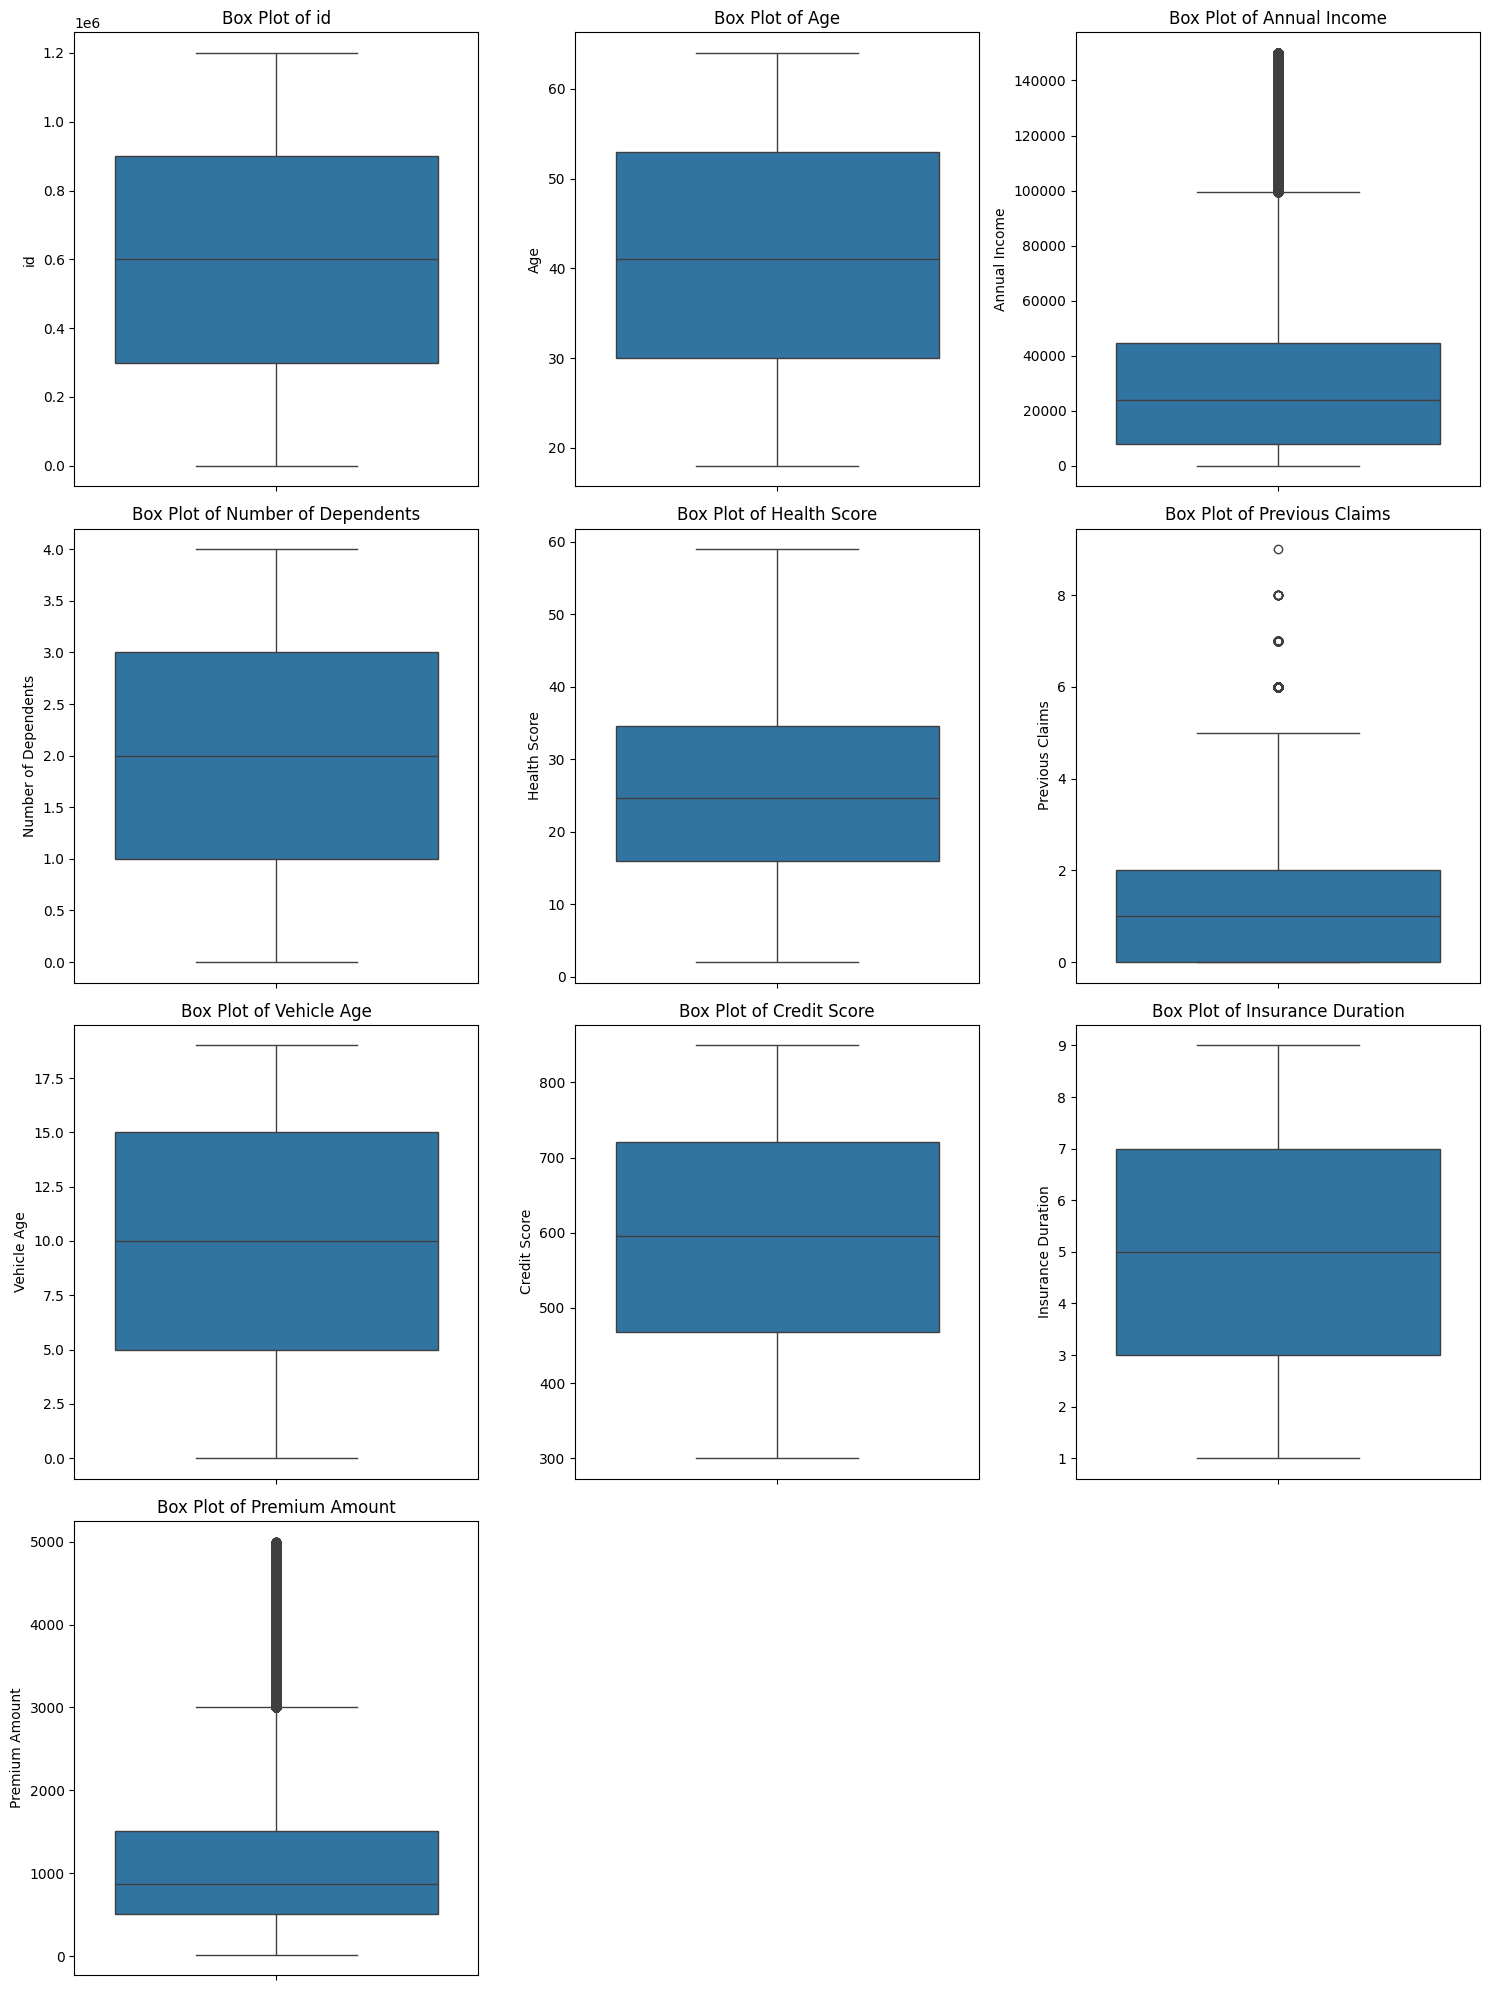

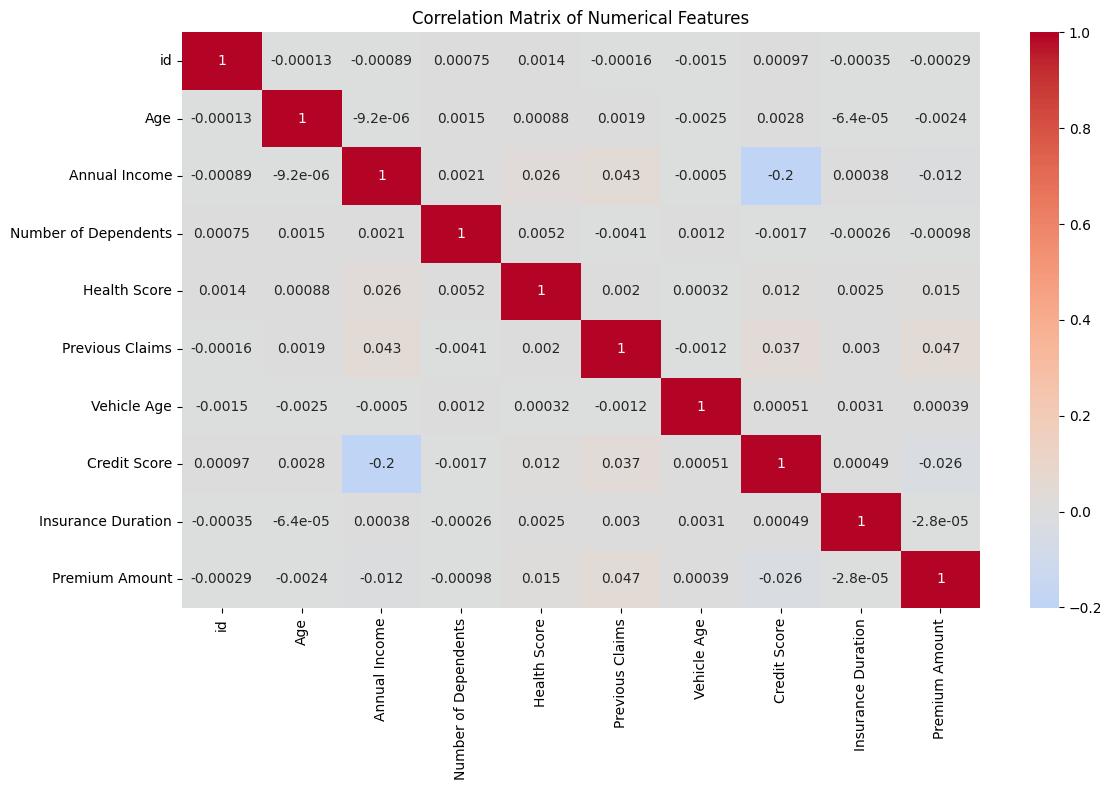

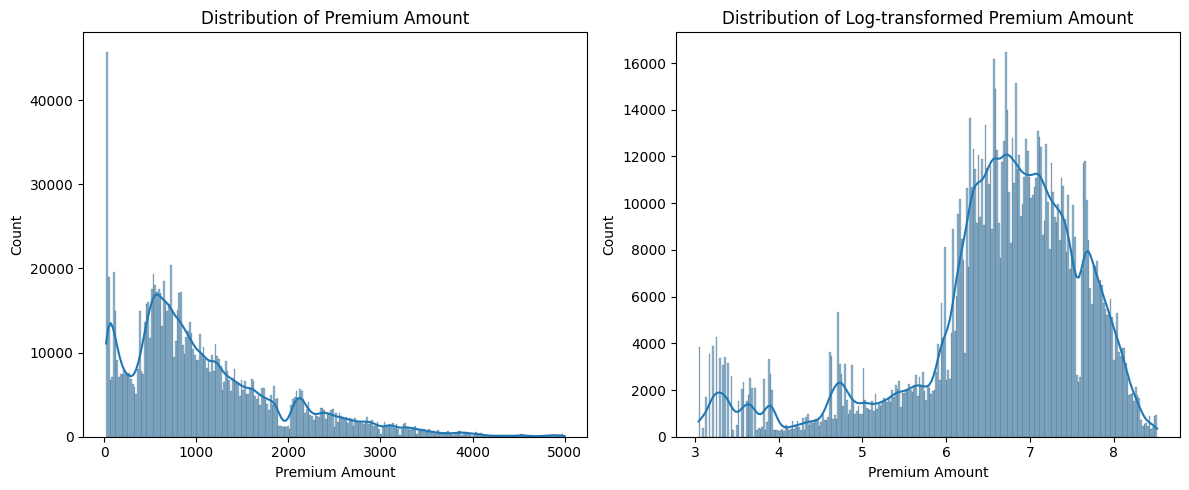

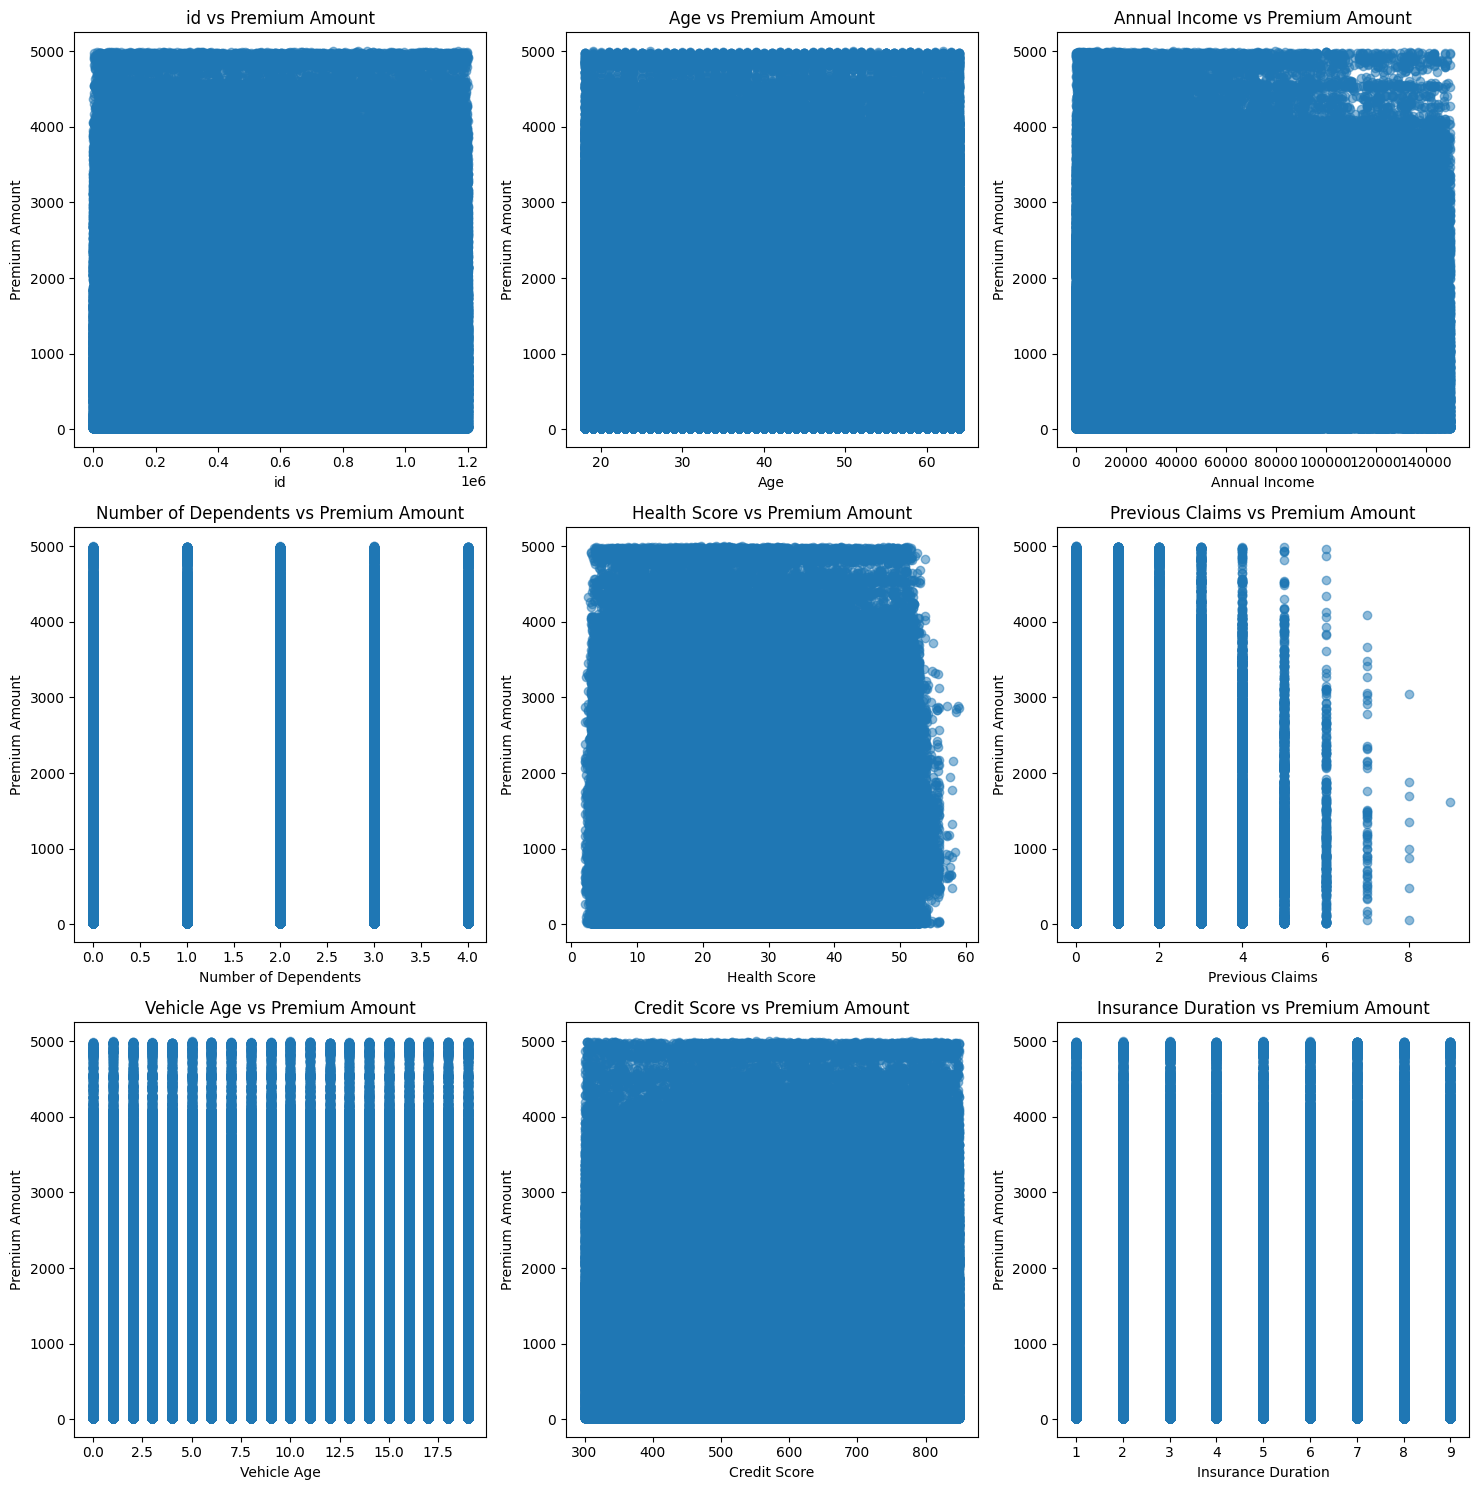

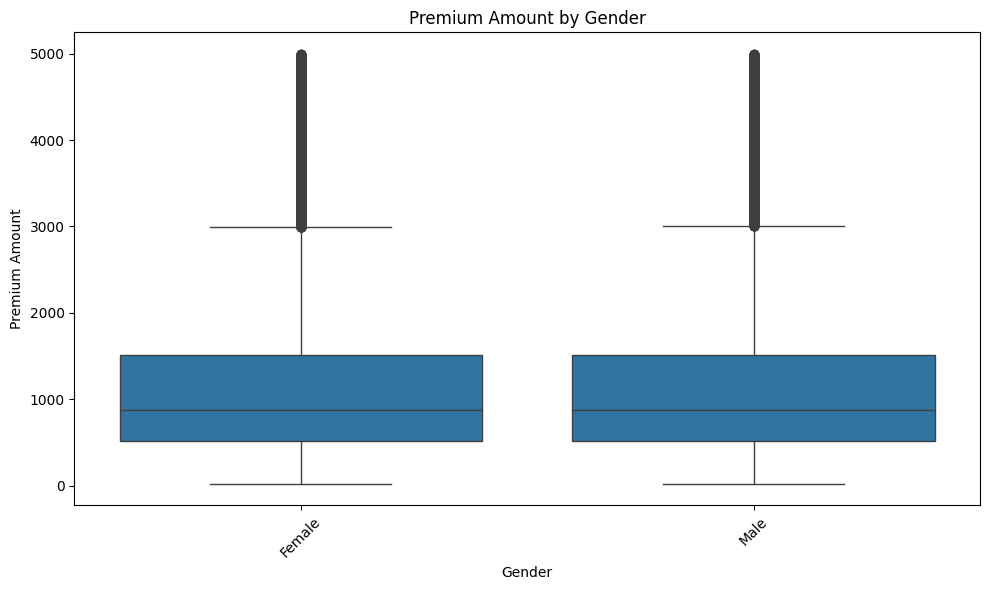

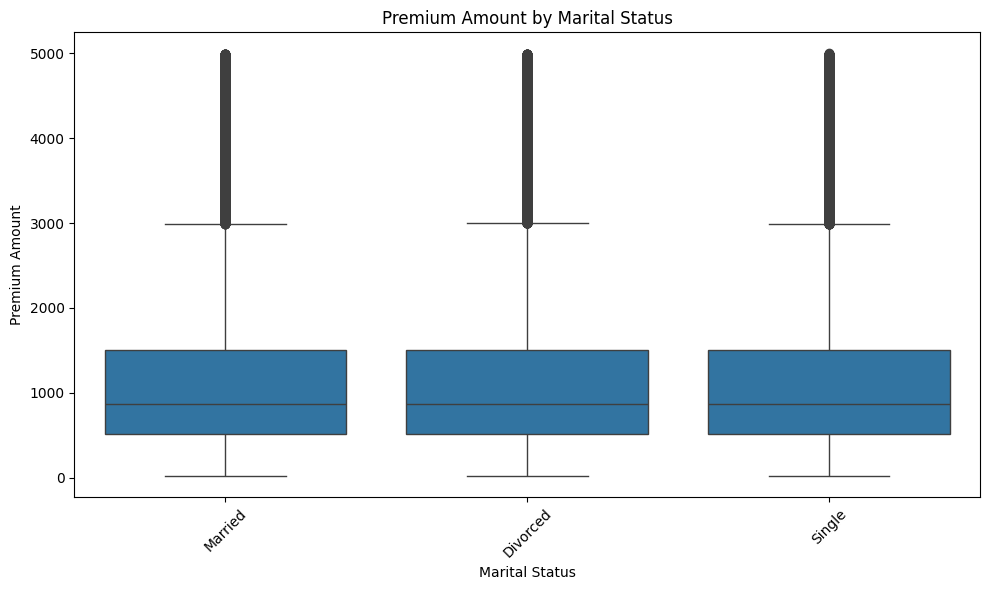

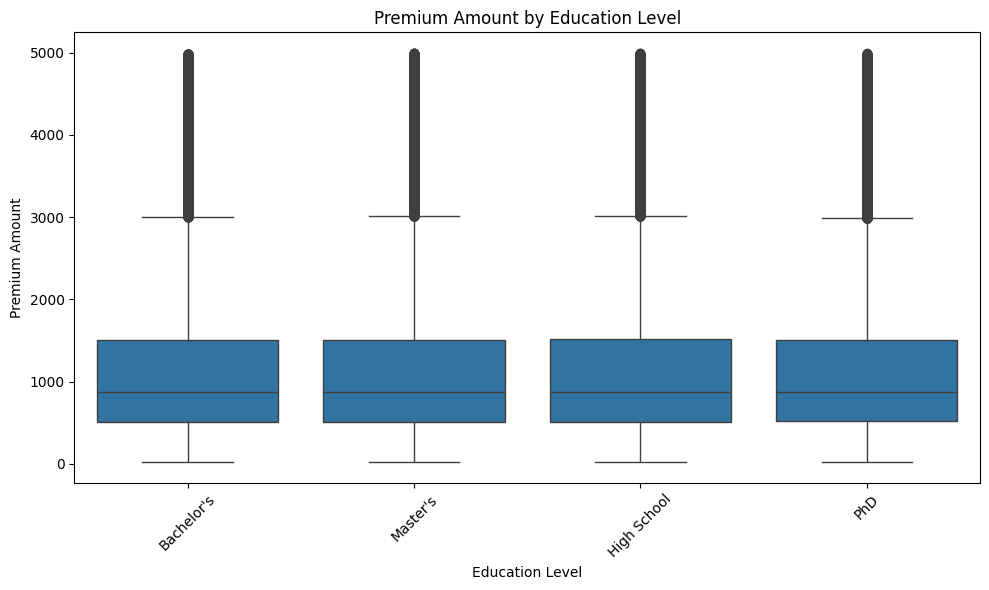

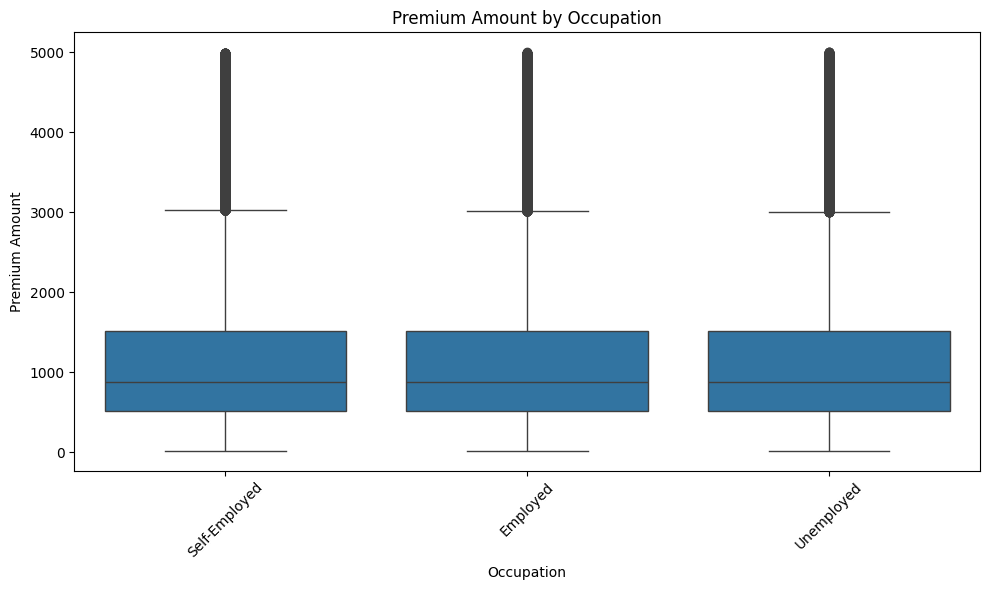

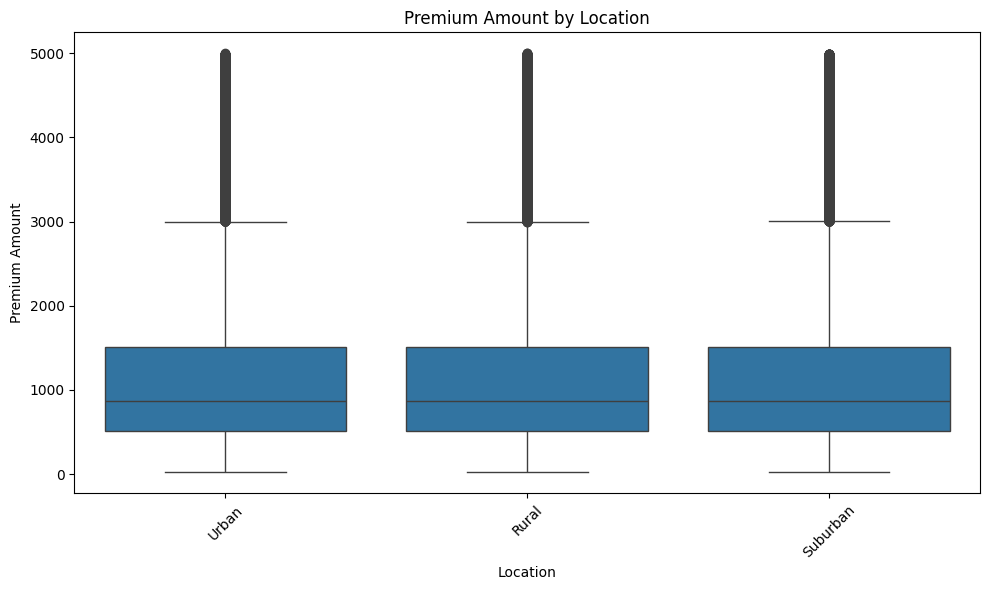

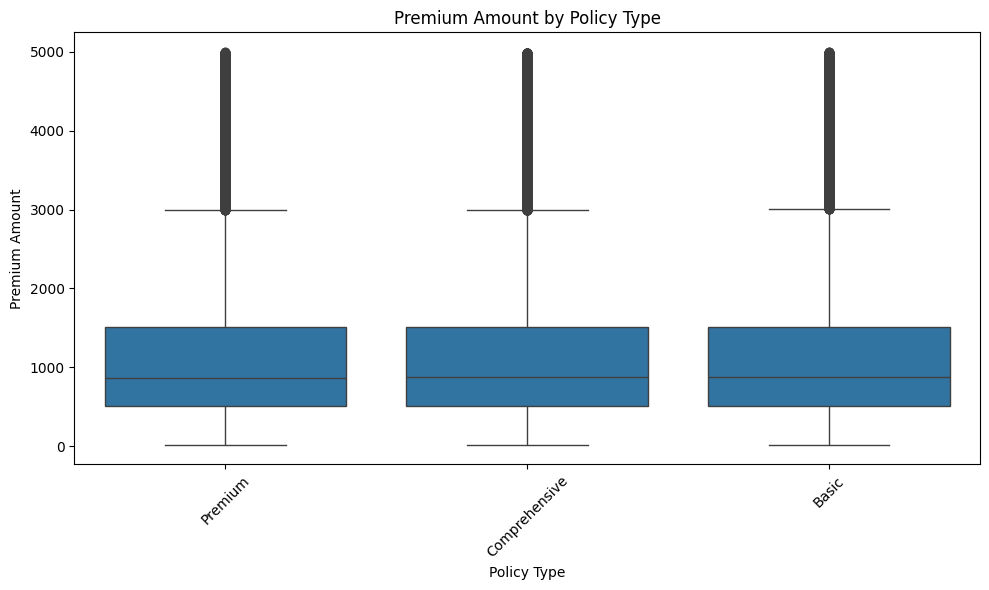

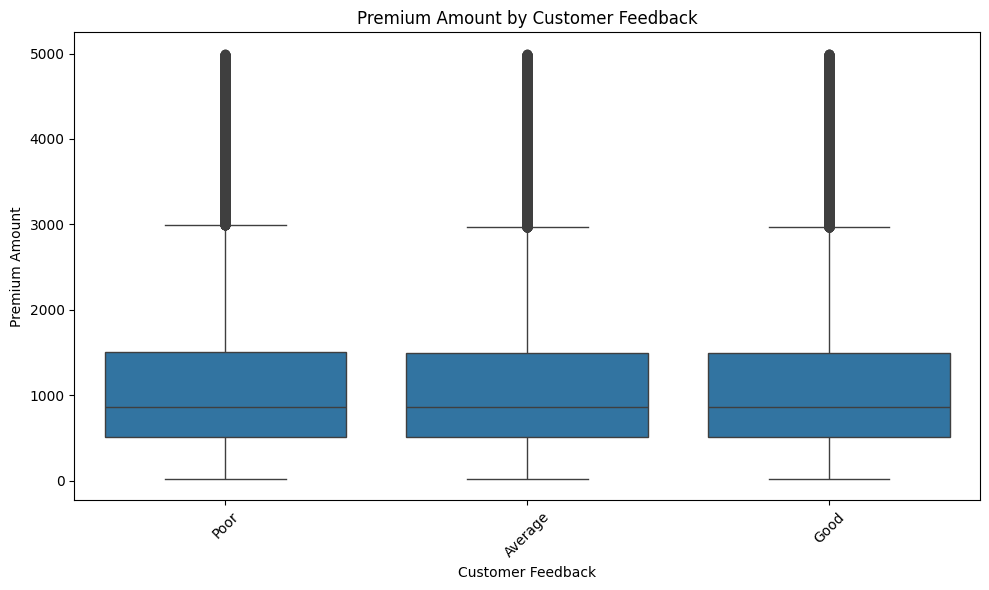

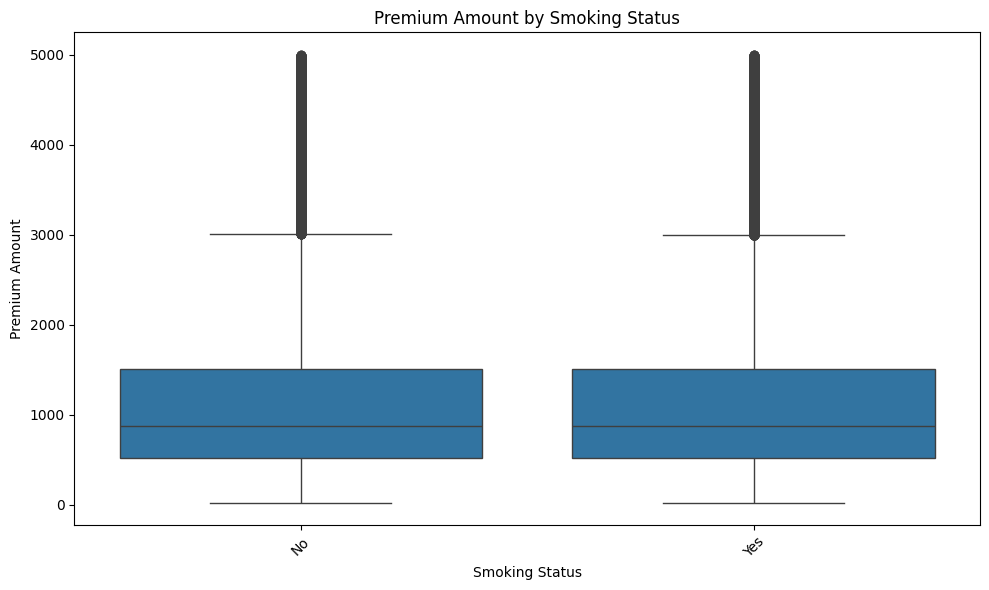

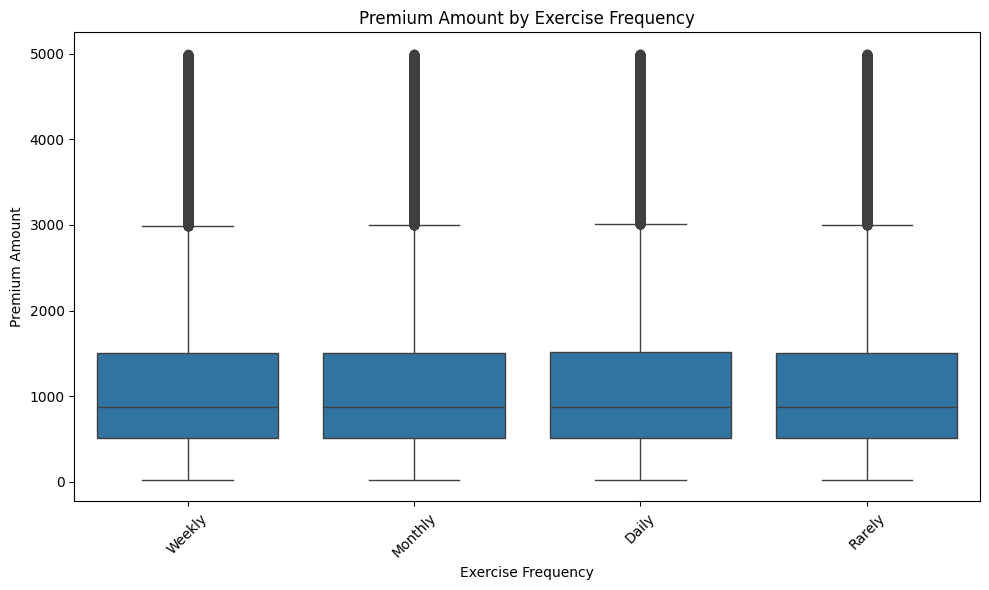

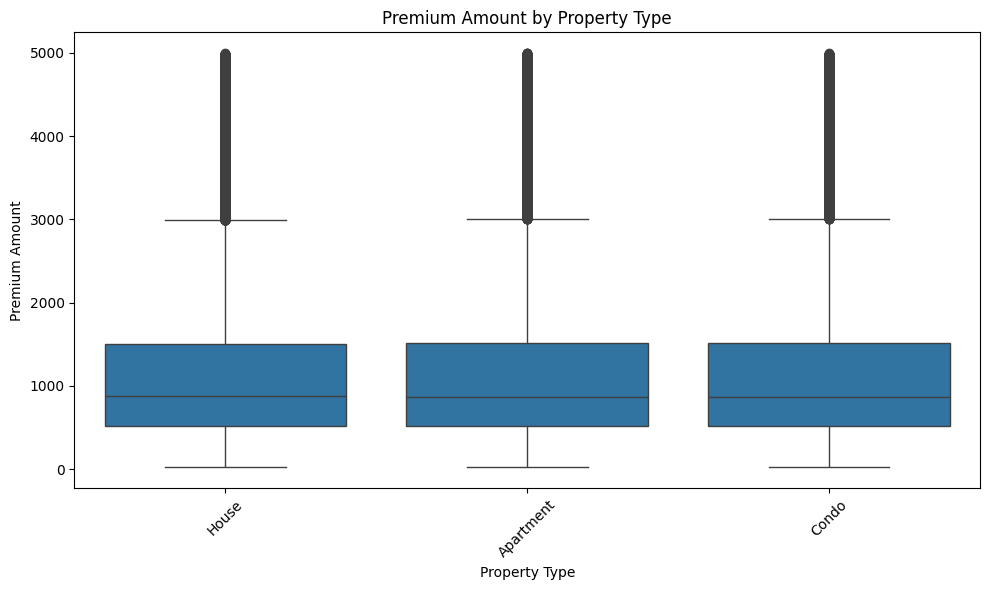


Performing EDA on test data...

Exploratory Data Analysis (Test Data)

1. Basic Information:
--------------------------------------------------

Dataset Shape: (800000, 20)

Feature Types:
id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score            float64
Location                 object
Policy Type              object
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date        object
Customer Feedback        object
Smoking Status           object
Exercise Frequency       object
Property Type            object
dtype: object

2. Missing Values Analysis:
--------------------------------------------------
                      Missing Values  Percentage
Age                        

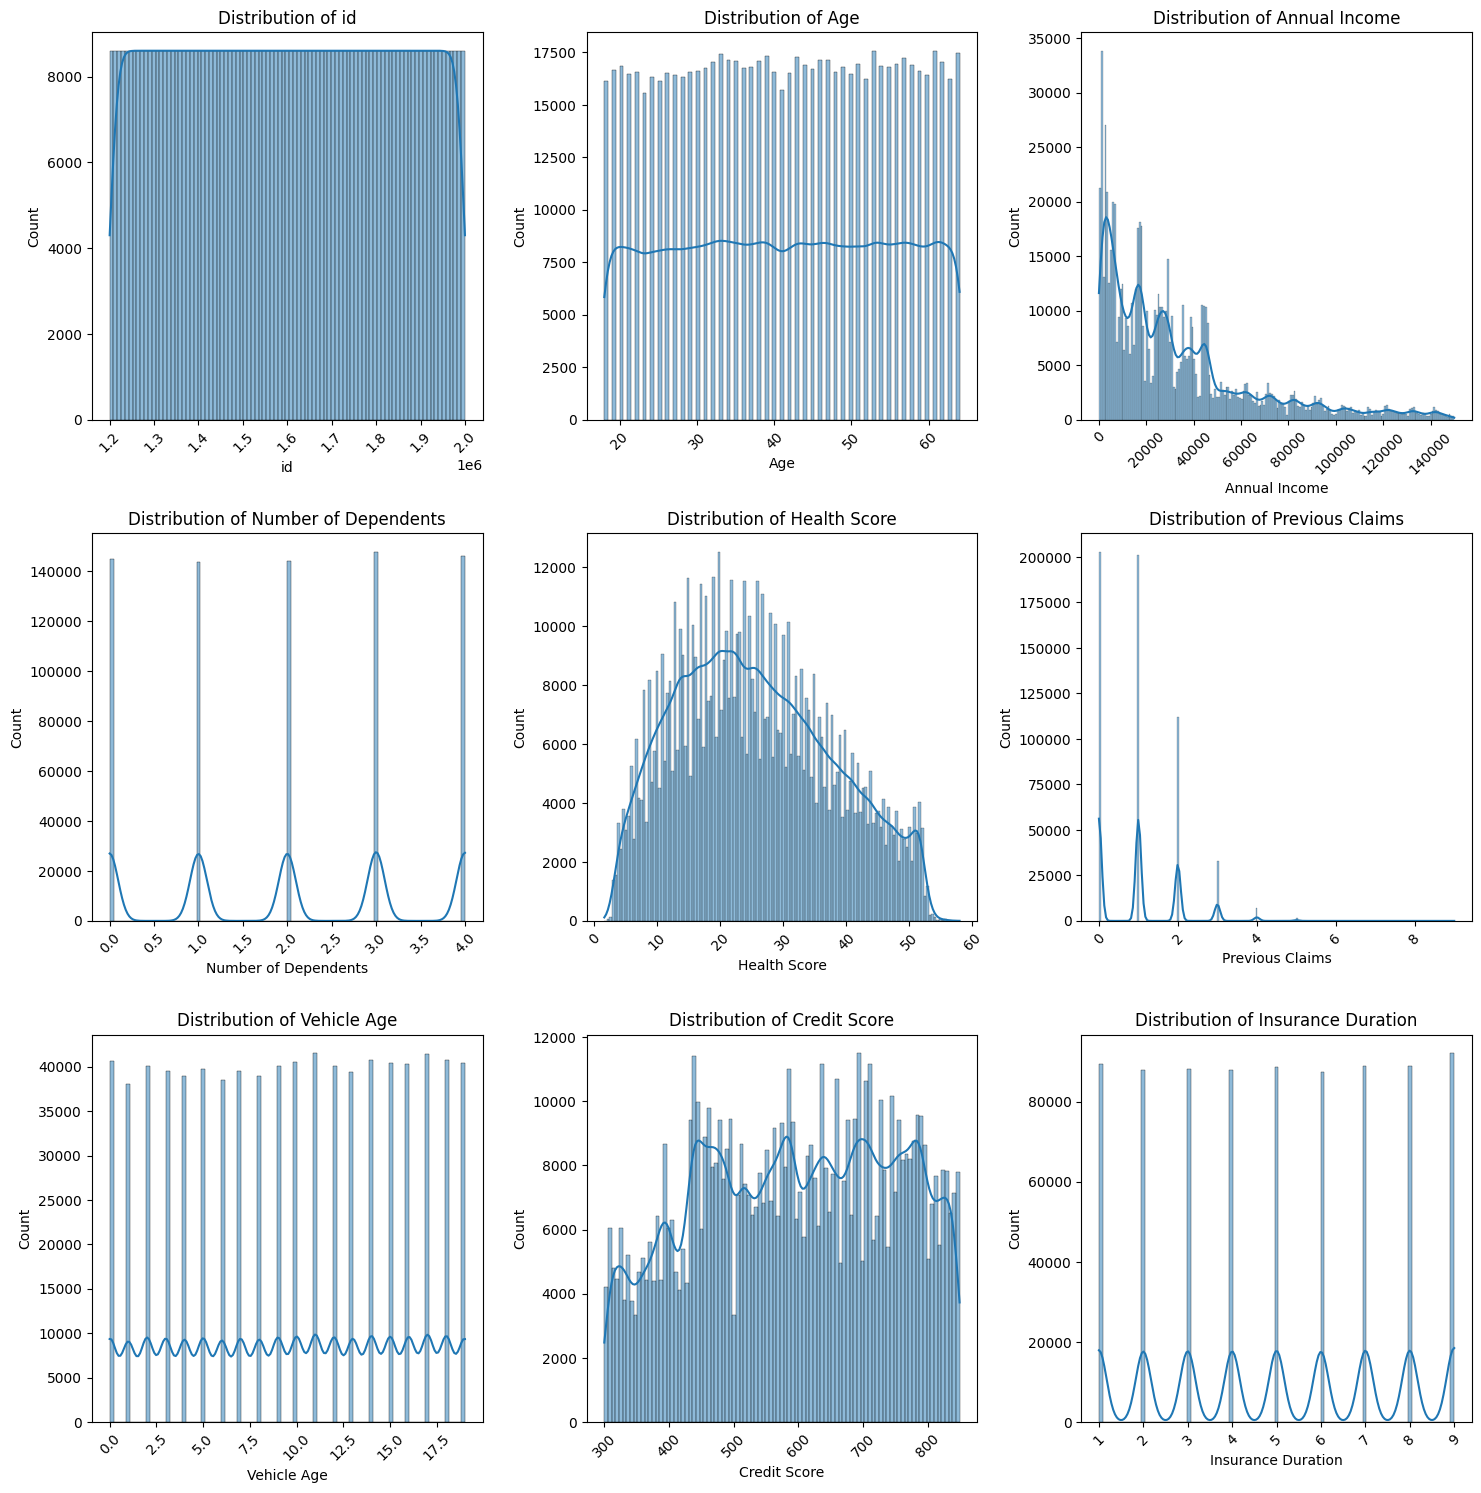

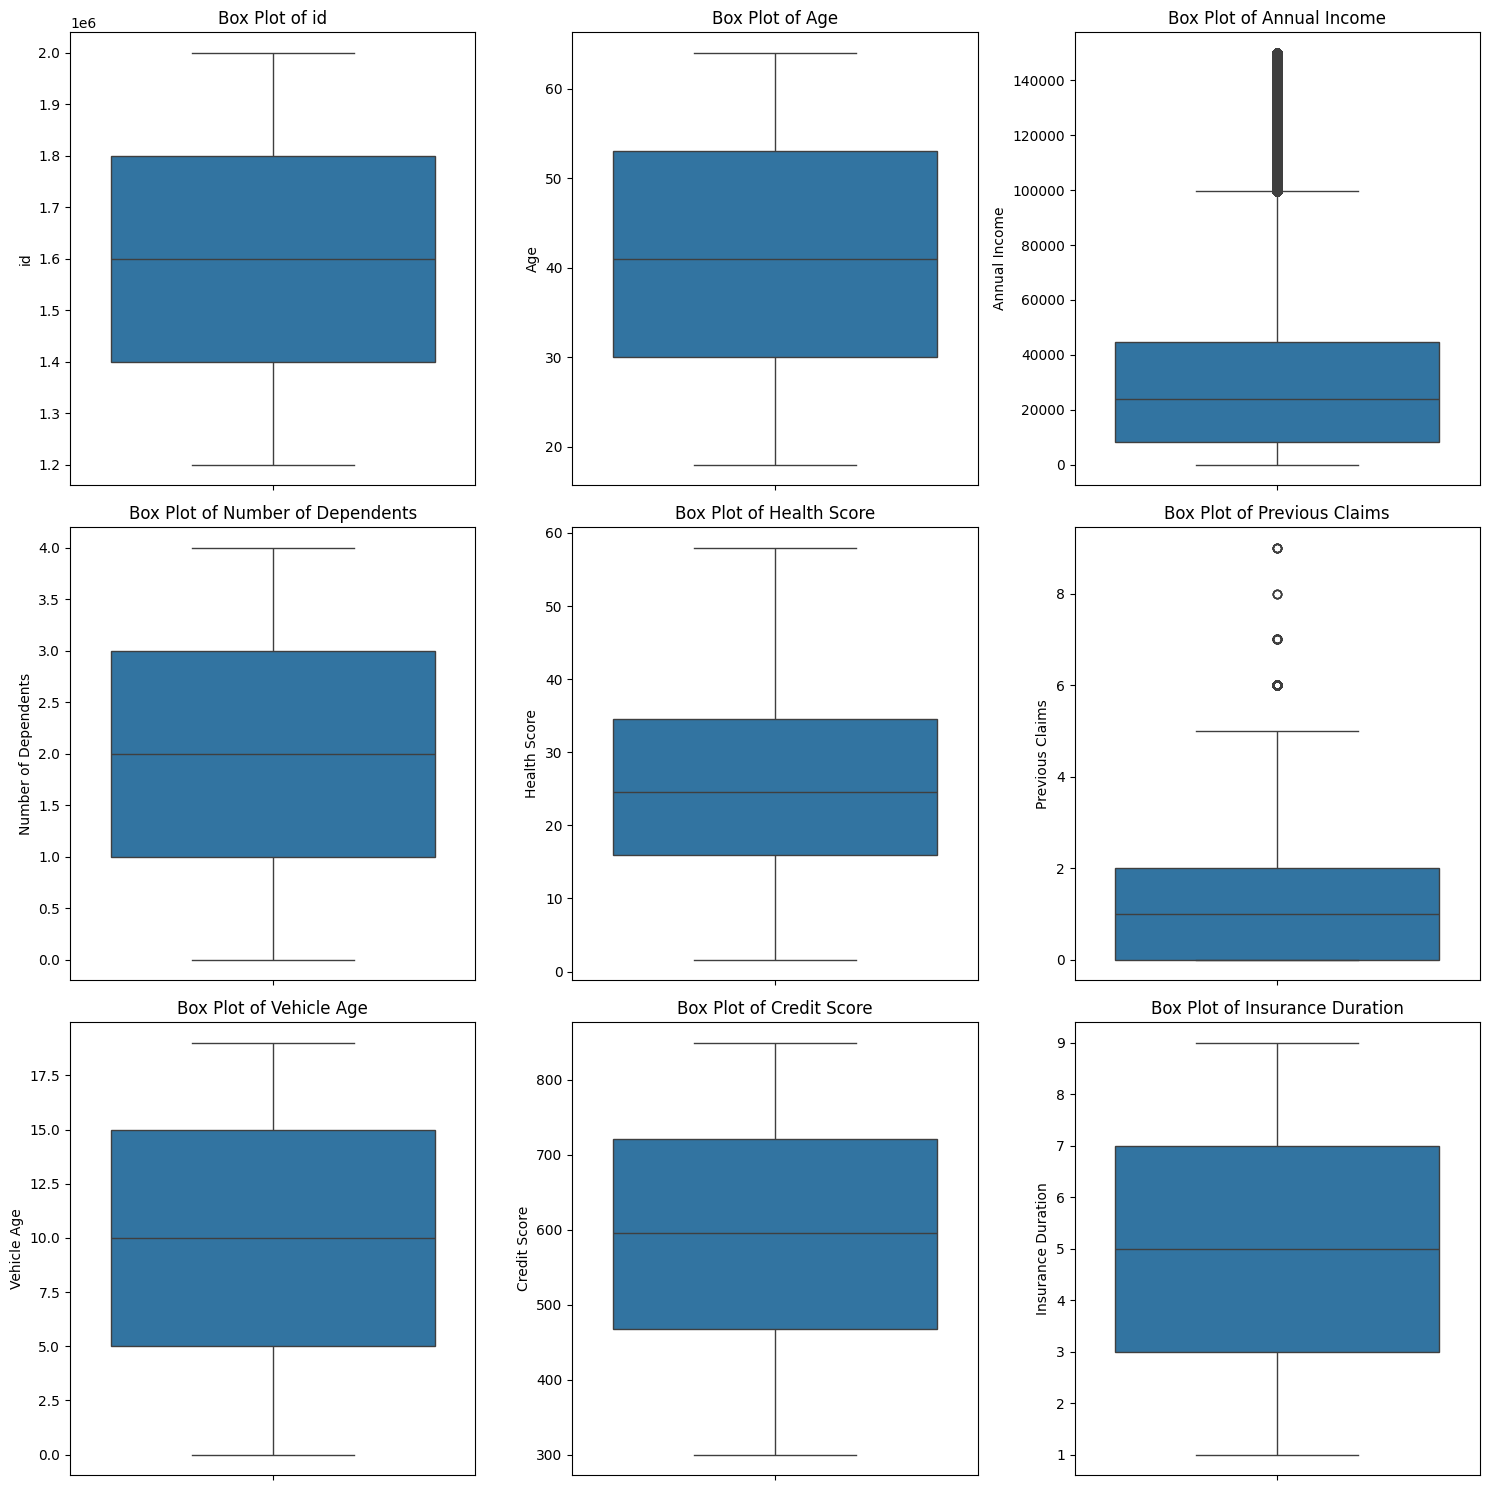

In [7]:
# Perform EDA on training and test data
print("\nPerforming EDA on training data...")
perform_eda(train_df, is_train=True)

print("\nPerforming EDA on test data...")
perform_eda(test_df, is_train=False)

monitor.checkpoint("EDA Complete")

 ## 4. Data Validation and Cleaning

In [8]:
def validate_data(df: pd.DataFrame) -> Tuple[bool, Dict[str, bool]]:
    checks = {
        'missing_values': df.isnull().sum().sum() == 0,
        'negative_values': (df.select_dtypes(include=['int64', 'float64']) >= 0).all().all(),
        'duplicates': df.duplicated().sum() == 0,
    }
    return all(checks.values()), checks

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Comprehensive data preprocessing pipeline

    Parameters:
        df: Input DataFrame

    Returns:
        Preprocessed DataFrame
    """
    df = df.copy()

    # Handle missing values
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    # Handle outliers using IQR method
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)


    return df

In [9]:
# Clean and validate data
print("\nValidating and cleaning data...")
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

train_valid, train_checks = validate_data(train_df)
test_valid, test_checks = validate_data(test_df)

print("Data validation results:")
print(f"Training data: {train_valid}")
print(f"Test data: {test_valid}")


Validating and cleaning data...
Data validation results:
Training data: True
Test data: True


 ## 5. Feature Engineering

In [10]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}
        self.scaler = RobustScaler()
        self.standard_scaler = StandardScaler()
        self.feature_names = None
        self.numeric_features = None
        self.categorical_features = None

    def standardize_column_names(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardizes column names by replacing spaces with underscores and converting to lowercase."""
        df.columns = df.columns.str.replace(' ', '_').str.replace('/', '_').str.lower()
        return df

    def transform_dates(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extracts date-related features and drops the original date column."""
        df = df.copy()
        if 'policy_start_date' in df.columns:
            df['policy_start_date'] = pd.to_datetime(df['policy_start_date'], errors='coerce')
            df['policy_start_year'] = df['policy_start_date'].dt.year
            df['policy_start_month'] = df['policy_start_date'].dt.month
            df['policy_start_quarter'] = df['policy_start_date'].dt.quarter
            df.drop('policy_start_date', axis=1, inplace=True)
        return df

    def create_interactions(self, df: pd.DataFrame) -> pd.DataFrame:
        """Generates basic and advanced interaction features."""
        df = df.copy()
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

        # Store numeric features for later use
        self.numeric_features = [col for col in numeric_cols if col not in ['id', 'premium_amount']]

        # Basic ratio features
        if 'annual_income' in df.columns and 'age' in df.columns:
            df['age_income_ratio'] = df['age'] / df['annual_income'].clip(lower=1)

        if 'annual_income' in df.columns and 'number_of_dependents' in df.columns:
            df['income_per_dependent'] = df['annual_income'] / (df['number_of_dependents'].clip(lower=0) + 1)

        if 'health_score' in df.columns and 'age' in df.columns:
            df['health_age_ratio'] = df['health_score'] / df['age'].clip(lower=1)

        # Risk-based features
        if all(col in df.columns for col in ['health_score', 'credit_score', 'age']):
            df['risk_score'] = (df['health_score'] * df['credit_score']) / df['age'].clip(lower=1)

        if all(col in df.columns for col in ['previous_claims', 'insurance_duration']):
            df['claims_duration_ratio'] = df['previous_claims'] / df['insurance_duration'].clip(lower=1)

        # Demographic features
        if 'number_of_dependents' in df.columns and 'annual_income' in df.columns:
            df['dependent_burden'] = df['number_of_dependents'] / df['annual_income'].clip(lower=1)

        if 'age' in df.columns and 'health_score' in df.columns:
            df['age_risk_factor'] = df['age'] * (1 / df['health_score'].clip(lower=1))

        # Insurance history features
        if 'previous_claims' in df.columns and 'insurance_duration' in df.columns:
            df['claims_frequency'] = df['previous_claims'] / df['insurance_duration'].clip(lower=1)

        # Polynomial features for key numeric columns
        for col in ['age', 'health_score', 'credit_score']:
            if col in df.columns:
                df[f'{col}_squared'] = df[col] ** 2

        return df

    def encode_categoricals(self, df: pd.DataFrame, is_training: bool = True) -> pd.DataFrame:
        """Encodes categorical features with Label Encoding."""
        df = df.copy()
        categorical_cols = df.select_dtypes(include=['object']).columns

        # Store categorical features for later use
        if is_training:
            self.categorical_features = list(categorical_cols)

        for col in categorical_cols:
            df[col] = df[col].fillna('Unknown')
            if is_training:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col])
            else:
                if col in self.label_encoders:
                    # Get unique categories and create a mapping dictionary
                    known_categories = set(self.label_encoders[col].classes_)
                    unique_vals = df[col].unique()
                    val_map = {val: (
                        self.label_encoders[col].transform([val])[0] if val in known_categories else -1
                    ) for val in unique_vals}
                    # Use replace which is much faster than map
                    df[col] = df[col].replace(val_map)
        return df

    def scale_features(self, df: pd.DataFrame, is_training: bool = True) -> pd.DataFrame:
        """Scales numerical features using RobustScaler."""
        df = df.copy()
        if not self.numeric_features:
            self.numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
            self.numeric_features = [col for col in self.numeric_features if col not in ['id', 'premium_amount']]

        if self.numeric_features:
            if is_training:
                df[self.numeric_features] = self.scaler.fit_transform(df[self.numeric_features].fillna(0))
            else:
                df[self.numeric_features] = self.scaler.transform(df[self.numeric_features].fillna(0))
        return df

    def transform(self, df: pd.DataFrame, is_training: bool = True) -> pd.DataFrame:
        """Applies all transformations in sequence."""
        df = self.standardize_column_names(df)
        df = self.transform_dates(df)
        df = self.create_interactions(df)
        df = self.encode_categoricals(df, is_training)
        df = self.scale_features(df, is_training)

        # Store feature names after all transformations
        self.feature_names = list(df.columns)
        return df

 ## 6. Model Training

In [11]:
class ModelTrainer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.y_true_all_folds = []
        self.y_pred_all_folds = []
        self.best_model = None
        self.feature_importance = None

    def train_xgboost(self, X_train, y_train, X_val=None, y_val=None):
        """Train XGBoost model with early stopping if validation data is provided."""
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 8,
            'learning_rate': 0.05,
            'n_estimators': 1000,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': self.random_state,
            'early_stopping_rounds': 50,
            'verbose': False
        }

        model = xgb.XGBRegressor(**params)

        if X_val is not None and y_val is not None:
            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)]
            )
        else:
            model.fit(X_train, y_train)

        return model

    def train_lightgbm(self, X_train, y_train, X_val=None, y_val=None):
        """Train LightGBM model with early stopping if validation data is provided."""
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'random_state': self.random_state,
            'n_estimators': 1000,
            'verbose': -1
        }

        model = lgb.LGBMRegressor(**params)

        if X_val is not None and y_val is not None:
            callbacks = [lgb.early_stopping(stopping_rounds=50)]
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=callbacks
            )
        else:
            model.fit(X_train, y_train)

        return model

    def train_catboost(self, X_train, y_train, X_val=None, y_val=None):
        """Train CatBoost model with early stopping if validation data is provided."""
        params = {
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'learning_rate': 0.05,
            'depth': 6,
            'iterations': 1000,
            'random_seed': self.random_state,
            'verbose': False
        }

        model = cb.CatBoostRegressor(**params)

        if X_val is not None and y_val is not None:
            model.fit(
                X_train, y_train,
                eval_set=(X_val, y_val),
                early_stopping_rounds=50,
                verbose=False
            )
        else:
            model.fit(X_train, y_train)

        return model

    def train_with_kfold(self, X, y, n_splits=5):
        """Train models using K-Fold cross validation."""
        print("\nStarting K-Fold Cross Validation Training...")
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)

        fold_scores = {
            'xgboost': [],
            'lightgbm': [],
            'catboost': []
        }

        model_predictions = {
            'xgboost': [],
            'lightgbm': [],
            'catboost': []
        }

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            print(f"\nTraining Fold {fold}/{n_splits}")

            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Train each model
            self.models[f'xgboost_fold_{fold}'] = self.train_xgboost(X_train, y_train, X_val, y_val)
            self.models[f'lightgbm_fold_{fold}'] = self.train_lightgbm(X_train, y_train, X_val, y_val)
            self.models[f'catboost_fold_{fold}'] = self.train_catboost(X_train, y_train, X_val, y_val)

            # Make predictions
            y_pred_xgb = self.models[f'xgboost_fold_{fold}'].predict(X_val)
            y_pred_lgb = self.models[f'lightgbm_fold_{fold}'].predict(X_val)
            y_pred_cb = self.models[f'catboost_fold_{fold}'].predict(X_val)

            # Store predictions
            model_predictions['xgboost'].append((fold, y_pred_xgb))
            model_predictions['lightgbm'].append((fold, y_pred_lgb))
            model_predictions['catboost'].append((fold, y_pred_cb))

            # Calculate RMSLE for each model
            fold_scores['xgboost'].append(np.sqrt(mean_squared_log_error(y_val, y_pred_xgb)))
            fold_scores['lightgbm'].append(np.sqrt(mean_squared_log_error(y_val, y_pred_lgb)))
            fold_scores['catboost'].append(np.sqrt(mean_squared_log_error(y_val, y_pred_cb)))

            # Store true values for this fold
            self.y_true_all_folds.extend(y_val)

            # Store ensemble predictions for this fold
            ensemble_pred = (y_pred_xgb + y_pred_lgb + y_pred_cb) / 3
            self.y_pred_all_folds.extend(ensemble_pred)

        # Print average scores
        print("\nAverage RMSLE scores across folds:")
        avg_scores = {}
        for model_name, scores in fold_scores.items():
            avg_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"{model_name}: {avg_score:.4f} (+/- {std_score:.4f})")
            avg_scores[model_name] = avg_score

        # Select best model type based on average performance
        best_model_type = min(avg_scores.items(), key=lambda x: x[1])[0]

        # Find the best fold for the best model type
        best_fold_idx = np.argmin(fold_scores[best_model_type])
        best_fold = best_fold_idx + 1

        # Set the best model
        self.best_model = self.models[f'{best_model_type}_fold_{best_fold}']

        # Get feature importance from the best model
        if hasattr(self.best_model, 'feature_importances_'):
            self.feature_importance = self.best_model.feature_importances_

        print(f"\nBest Model: {best_model_type} from fold {best_fold}")
        return self.models

    def get_y_true_and_pred(self):
        """Get true and predicted values from all folds."""
        return np.array(self.y_true_all_folds), np.array(self.y_pred_all_folds)

    def evaluate_models(self):
        """Evaluate all trained models using RMSLE metric."""
        if not self.y_true_all_folds or not self.y_pred_all_folds:
            print("No predictions available. Please train the models first.")
            return None

        y_true = np.array(self.y_true_all_folds)
        y_pred = np.array(self.y_pred_all_folds)

        metrics = {
            'RMSLE': np.sqrt(mean_squared_log_error(y_true, y_pred)),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)
        }

        print("\nModel Evaluation Metrics:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")

        return metrics

    def predict(self, X):
        """Make predictions using the best model."""
        if self.best_model is None:
            raise ValueError("No model available. Please train the models first.")
        return self.best_model.predict(X)

## 7. Model Training and Evaluation

In [12]:
# Start the training pipeline
print("\nStarting main training pipeline...")

# Initialize the feature engineer
fe = FeatureEngineer()

# Prepare train and test data
print("Preparing train and test data...")
X_train = train_df.drop(['Premium Amount', 'id'], axis=1)
y_train = np.log1p(train_df['Premium Amount'])  # Log transform target
X_test = test_df.drop(['id'], axis=1)

# Apply feature transformations
print("Transforming features...")
X_train_transformed = fe.transform(X_train, is_training=True)
X_test_transformed = fe.transform(X_test, is_training=False)
print("Features prepared!")

# Initialize the model trainer
trainer = ModelTrainer(random_state=42)

# Train models with K-Fold Cross-Validation
print("Training models with K-Fold Cross-Validation...")
try:
    models = trainer.train_with_kfold(X_train_transformed, y_train)
    print("Training completed!")

    # Evaluate models
    print("Evaluating models...")
    evaluations = trainer.evaluate_models()
    print(f"Model Evaluations: {evaluations}")

    # Make predictions with the best model
    print("Making predictions with the best model...")
    if trainer.best_model is not None:
        test_predictions = trainer.predict(X_test_transformed)

        # Transform predictions back from log space
        final_predictions = np.expm1(test_predictions)

        # Prepare submission
        submission = pd.DataFrame({
            'id': test_df['id'],
            'Premium Amount': final_predictions
        })

        # Save predictions
        output_path = 'submission.csv'
        submission.to_csv(output_path, index=False)
        print(f"\nPredictions saved to {output_path}")

    else:
        print("Error: Best model not selected properly during training.")
except Exception as e:
    print(f"Error during model training/prediction: {str(e)}")

monitor.checkpoint("Analysis Complete")

# Print final execution summary
print("\nExecution Summary:")
for checkpoint, time_taken in monitor.checkpoints.items():
    print(f"{checkpoint}: {time_taken:.2f}s")
print(f"Final Memory Usage: {monitor.get_memory_usage():.2f} MB")


Starting main training pipeline...
Preparing train and test data...
Transforming features...
Features prepared!
Training models with K-Fold Cross-Validation...

Starting K-Fold Cross Validation Training...

Training Fold 1/5
[0]	validation_0-rmse:1.08381	validation_1-rmse:1.08470
[1]	validation_0-rmse:1.07995	validation_1-rmse:1.08095
[2]	validation_0-rmse:1.07641	validation_1-rmse:1.07756
[3]	validation_0-rmse:1.07321	validation_1-rmse:1.07447
[4]	validation_0-rmse:1.07052	validation_1-rmse:1.07189
[5]	validation_0-rmse:1.06789	validation_1-rmse:1.06938
[6]	validation_0-rmse:1.06563	validation_1-rmse:1.06723
[7]	validation_0-rmse:1.06437	validation_1-rmse:1.06608
[8]	validation_0-rmse:1.06318	validation_1-rmse:1.06501
[9]	validation_0-rmse:1.06219	validation_1-rmse:1.06414
[10]	validation_0-rmse:1.06027	validation_1-rmse:1.06233
[11]	validation_0-rmse:1.05855	validation_1-rmse:1.06072
[12]	validation_0-rmse:1.05698	validation_1-rmse:1.05926
[13]	validation_0-rmse:1.05620	validation_1